## Table of contents :
* [I - Pre-datacleaning (build a unique dataset)](#first)
    * [1 - Build data dictionaries from json files (2015 & 2016)](#first_1)
    * [2 - Find common variables from data dictionaries (2015 & 2016)](#first_2)
    * [3 - Build of the work subset from csv files (2015 & 2016)](#first_3)
    * [4 - Union of the two datasets (2015, 2016)](#first_4)
* [II - Datacleaning from all the data (2015 + 2016)](#second)
    * [1 - Observation of descriptions of energy variables](#second_1)
    * [2 - Observation of descriptions of properties variables](#second_2) 
    * [3 - Observation of descriptions of geographic variables](#second_3)
    * [4 - Build subset for analysis](#second_4)
* [III - Exploratory data analysis (EDA)](#third)
    * [1 - Dataset overview](#third_1)
    * [2 - Univariate analysis ](#third_2)
    * [3 - Feature engineering ](#third_3)
    * [4 - Feature scaling](#third_4)
    * [5 - Factorial analysis (PCA)](#third_5)
    * [6 - Multivariate analysis](#third_6)
* [ IV - Build modeling dataset](#fourth)

In [1]:
# Import custom packages & modules
import sys
sys.path.append("..")
from src.datacleaner import *
from src.analyzer.univariate import *
from src.analyzer.multivariate import *
from src.analyzer.pca import PCAlizer

# I - Pre-datacleaning (build a unique dataset) <a class="anchor" id="first"></a>

### 1 - Build data dictionaries from json files (2015 & 2016) <a class="anchor" id="first_1"></a>

#### 1.1 - Data dictionary (2015)

In [2]:
# Build 2015 data dictionary as dataframe
metadata_2015 = pd.read_json('../data/json/socrata_metadata_2015-building-energy-benchmarking.json',
                             orient='index')
data_dict_2015 = pd.DataFrame(metadata_2015.T['columns'][0])
data_dict_2015.head(2)

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,width,cachedContents,format,computationStrategy
0,350402298,OSEBuildingID,number,A unique identifier assigned to each property ...,seattlebuildingid,1,number,46302822,182.0,"{'largest': '50059', 'non_null': 3340, 'averag...","{'precisionStyle': 'standard', 'noCommas': 'tr...",NaN
1,350402299,DataYear,text,NaN,datayear,2,text,46302823,196.0,"{'largest': '2015', 'non_null': 3340, 'null': ...",{},NaN


#### 1.2 - Data dictionary (2016)

In [3]:
# Build 2016 data dictionary as dataframe
metadata_2016 = pd.read_json('../data/json/socrata_metadata_2016-building-energy-benchmarking.json',
                             orient='index')
data_dict_2016 = pd.DataFrame(metadata_2016.T['columns'][0])
data_dict_2016.head(2)

,id,name,dataTypeName,description,fieldName,position,renderTypeName,tableColumnId,cachedContents,format,width
0,349768636,OSEBuildingID,number,A unique identifier assigned to each property ...,osebuildingid,1,number,62418341,"{'largest': '50226', 'non_null': 3376, 'averag...",{'groupSeparator': ''},NaN
1,349768619,DataYear,number,Calendar year (January-December) represented b...,datayear,2,number,62418324,"{'largest': '2016', 'non_null': 3376, 'average...","{'precisionStyle': 'standard', 'noCommas': 'tr...",100.0


### 2 - Find common variables from data dictionaries (2015 & 2016) <a class="anchor" id="first_2"></a>

In [4]:
# Uncommon columns (columns specific to 2015)
cols_from_2015 = [v for v in data_dict_2015['name'].tolist() if v not in data_dict_2016['name'].tolist()]

# Uncommon columns (columns specific to 2016)
cols_from_2016 = [v for v in data_dict_2016['name'].tolist() if v not in data_dict_2015['name'].tolist()]

In [5]:
print(f'Specific columns to 2015 : (total = {len(cols_from_2015)})\n')
for col in cols_from_2015:
    print(f'{col :-<70}')
    
print(f'\nSpecific columns to 2016 : (total = {len(cols_from_2016)})\n')
for col in cols_from_2016:
    print(f'{col :-<70}')

Specific columns to 2015 : (total = 10)

Location--------------------------------------------------------------
OtherFuelUse(kBtu)----------------------------------------------------
GHGEmissions(MetricTonsCO2e)------------------------------------------
GHGEmissionsIntensity(kgCO2e/ft2)-------------------------------------
Comment---------------------------------------------------------------
2010 Census Tracts----------------------------------------------------
Seattle Police Department Micro Community Policing Plan Areas---------
City Council Districts------------------------------------------------
SPD Beats-------------------------------------------------------------
Zip Codes-------------------------------------------------------------

Specific columns to 2016 : (total = 9)

Address---------------------------------------------------------------
City------------------------------------------------------------------
State-------------------------------------------------------------

**Comments :**
- 1 - Location column of the 2015 dataset contains the following six columns from the 2016 dataset : 
  - **Location = 'Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude'**
  (next step : decompose Location column)
- 2 - **Comment(s)** columns look similar (next step : count NaN)
- 3 - Check if :
    - **'TotalGHGEmissions' == 'GHGEmissions(MetricTonsCO2e)' (2015)**
    - **'GHGEmissionsIntensity' == 'GHGEmissionsIntensity(kgCO2e/ft2)' (2015)**

### 3 - Build of the work subset from csv files (2015 & 2016) <a class="anchor" id="first_3"></a>

#### 3.1 - 2015 dataset

In [6]:
# Build 2015 csv as dataframe
df_2015 = pd.read_csv('../data/csv/2015-building-energy-benchmarking.csv')
# Display rows & columns counts
print(df_2015.shape)
# Display first row
df_2015.head(1)

(3340, 47)


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,...,GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,...,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081


#### 3.2 - 2016 dataset

In [7]:
# Build 2016 csv as dataframe
df_2016 = pd.read_csv('../data/csv/2016-building-energy-benchmarking.csv')
# Display rows & columns counts
print(df_2016.shape)
# Display first row
df_2016.head(1)

(3376, 46)


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1156514.25,3946027.0,12764.5293,1276453.0,False,NaN,Compliant,NaN,249.98,2.83


#### 3.3 - Decomposition of the Location column from 2015 dataset compared to the columns of 2016

In [8]:
import json

# Function which remove specific patterns from string data and convert it as python dictionary
def clean_string(s):
    s = s.replace('\"', '\'').replace('\'human_address\': \'{', '').replace('}\'', '').replace('\'', '\"')
    d = dict(json.loads(s))
    return d

# Map clean_string function to Location column from 2015 dataset
df_2015.Location = df_2015.Location.map(lambda s: clean_string(s) if pd.isna(s) is False else s)
# Display result
df_2015.Location.head(1)[0]

{'latitude': '47.61219025',
 'longitude': '-122.33799744',
 'address': '405 OLIVE WAY',
 'city': 'SEATTLE',
 'state': 'WA',
 'zip': '98101'}

In [9]:
# Create the columns which are within Location variable of the 2015 dataset, from 2016 dataset column labels

# Iterate over 2016 column labels concerned (which are the first six)
for col in cols_from_2016[:6]:
    if col == 'ZipCode':
        df_2015[col] = df_2015['Location'].map(lambda d: d['zip'] if pd.isna(d) is False else d)
    else:
        df_2015[col] = df_2015['Location'].map(lambda d: d[col.lower()] if pd.isna(d) is False else d)

# Remove useless Location column
delete_cols(df_2015, 'Location')
# Display result
df_2015.head(1)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,...,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes,Address,City,State,ZipCode,Latitude,Longitude
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1,...,14.0,NaN,31.0,18081,405 OLIVE WAY,SEATTLE,WA,98101,47.61219025,-122.33799744


#### 3.4 - Checking for similarities between the comment columns

In [10]:
comments_col_2015, comments_col_2016 = 'Comment', 'Comments'
# Display NaN count
print(comments_col_2015 + ' (NaN) : ' + count_nan(df_2015, comments_col_2015))
print(comments_col_2016 + ' (NaN) :  ' + count_nan(df_2016, comments_col_2016))
# Remove comment columns
delete_cols(df_2015, 'Comment')
delete_cols(df_2016, 'Comments')

Comment (NaN) : 3327  (100%)
Comments (NaN) :  3376  (100%)


#### 3.5 - GHG (GreenHouse Gas emissions) column compliance verification 

#### 3.5.1 - Column compliance verification :
- _'GHGEmissions(MetricTonsCO2e)'_ (2015)
- _'TotalGHGEmissions'_ (2016)

In [11]:
# Check if the descriptions are identical

ghgt_col_2015, ghgt_col_2016 = 'GHGEmissions(MetricTonsCO2e)', 'TotalGHGEmissions'

desc_ghgt_2015 = data_dict_2015[data_dict_2015['name'] == ghgt_col_2015]['description'].iloc[0]
print(desc_ghgt_2015+'\n')

desc_ghgt_2016 = data_dict_2016[data_dict_2016['name'] == ghgt_col_2016]['description'].iloc[0]
print(desc_ghgt_2016+'\n')

print("Identical descriptions : {}".format(desc_ghgt_2015 == desc_ghgt_2016))

# Check if the data types are identical (float64)

ghgt_cols_types_cond = df_2015[ghgt_col_2015].iloc[0].dtype == df_2016[ghgt_col_2016].iloc[0].dtype
print("Identical data type : {}".format(ghgt_cols_types_cond))

# After a thorough reading of the descriptions we notice that they can be considered identical.
# That of 2016 differs slightly by integrating this sentence : 'until the 2016 factor is available'

The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu. 

The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh until the 2016 factor is available. Enwave s

#### 3.5.2 - Column compliance verification :
- _'GHGEmissionsIntensity(kgCO2e/ft2)'_ (2015)
- _'GHGEmissionsIntensity'_ (2016)

In [12]:
# Check if the descriptions are identical

ghgI_col_2015, ghgI_col_2016 = 'GHGEmissionsIntensity(kgCO2e/ft2)', 'GHGEmissionsIntensity'

desc_ghgI_2015 = data_dict_2015[data_dict_2015['name'] == ghgI_col_2015]['description']
desc_ghgI_2015 = desc_ghgI_2015.iloc[0].replace('\t\n', '')
print(desc_ghgI_2015+'\n')

desc_ghgI_2016 = data_dict_2016[data_dict_2016['name'] == ghgI_col_2016]['description'].iloc[0]
print(desc_ghgI_2016+'\n')

print("Identical descriptions : {}".format(desc_ghgI_2015 == desc_ghgI_2016))

# Check if the data types are identical (float64)

ghgI_cols_types_cond = df_2015[ghgI_col_2015].iloc[0].dtype == df_2016[ghgI_col_2016].iloc[0].dtype
print("Identical data type : {}".format(ghgI_cols_types_cond))

Total Greenhouse Gas Emissions divided by property's gross floor area, measured in kilograms of carbon dioxide equivalent per square foot. This calculation uses a GHG emissions factor from Seattle City Light's portfolio of generating resources

Total Greenhouse Gas Emissions divided by property's gross floor area, measured in kilograms of carbon dioxide equivalent per square foot. This calculation uses a GHG emissions factor from Seattle City Light's portfolio of generating resources

Identical descriptions : True
Identical data type : True


### 4 - Union of the two datasets (2015, 2016) <a class="anchor" id="first_4"></a>

In [13]:
# Rename variables by following the naming convention from the dataset for 2015

df_2015.rename(columns={'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions',
                        'GHGEmissionsIntensity(kgCO2e/ft2)': 'GHGEmissionsIntensity'}, inplace=True)

# Remove the Zip Codes column which does not correspond to that of the Location variable
delete_cols(df_2015, 'Zip Codes')

In [14]:
# Extract the columns specific to the 2015 dataset
cols_spec_2015 = [col for col in df_2015.columns.tolist() if col not in df_2016.columns.tolist()]

# Display NaN count for each column
display_nan_count_for_each_col(df_2015, cols_spec_2015)

OtherFuelUse(kBtu)---------------------------------------------------------------------------------- 10  (0%)
2010 Census Tracts---------------------------------------------------------------------------------- 3116  (93%)
Seattle Police Department Micro Community Policing Plan Areas--------------------------------------- 2  (0%)
City Council Districts------------------------------------------------------------------------------ 3127  (94%)
SPD Beats------------------------------------------------------------------------------------------- 2  (0%)


In [15]:
# OtherFuelUse(kBtu) seems to be interesting, we look at its distribution
measures_table(df_2015['OtherFuelUse(kBtu)'])

,OtherFuelUse(kBtu)
count,3.330000e+03
mean,7.142301e+03
std,1.962790e+05
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,8.269669e+06


In [16]:
# We see here that zero values are overrepresented (Q3 = 0).
# By analyzing the rest of the variables we decide to remove the set which does not seem relevant
delete_cols(df_2015, cols_spec_2015)

In [17]:
# Concatenate the two standardized dataframes (2015 et 2016)
seattle_data = pd.concat([df_2015, df_2016], ignore_index=True, sort=False)
seattle_data.shape

(6716, 45)

# II - Datacleaning from all the data (2015 + 2016) <a class="anchor" id="second"></a>

In [18]:
seattle_data.head(2)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,...,GHGEmissionsIntensity,DefaultData,ComplianceStatus,Outlier,Address,City,State,ZipCode,Latitude,Longitude
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1.0,...,2.64,No,Compliant,NaN,405 OLIVE WAY,SEATTLE,WA,98101,47.61219025,-122.33799744
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1.0,...,2.38,No,Compliant,NaN,724 PINE ST,SEATTLE,WA,98101,47.61310583,-122.33335756


### 1 - Observation of descriptions of energy variables <a class="anchor" id="second_1"></a>

In [19]:
# Observation of energy variables from our data dictionary

# Display full description of variables
pd.set_option('display.max_colwidth', 1)

# Energy variables
energy_var = ['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)',
              'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUse(kBtu)',
              'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 
              'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
              'TotalGHGEmissions', 'GHGEmissionsIntensity']

energy_var_data_dict = data_dict_2016[data_dict_2016.name.isin(energy_var)][['name', 'description']]
energy_var_data_dict.index = pd.RangeIndex(1, len(energy_var_data_dict.index)+1)
# energy_var_data_dict = energy_var_data_dict.style.hide_index()
energy_var_data_dict

,name,description
1,SiteEUI(kBtu/sf),"Site Energy Use Intensity (EUI) is a property's Site Energy Use divided by its gross floor area. Site Energy Use is the annual amount of all the energy consumed by the property on-site, as reported on utility bills. Site EUI is measured in thousands of British thermal units (kBtu) per square foot."
2,SiteEUIWN(kBtu/sf),Weather Normalized (WN) Site Energy Use Intensity (EUI) is a property's WN Site Energy divided by its gross floor area (in square feet). WN Site Energy is the Site Energy Use the property would have consumed during 30-year average weather conditions. WN Site EUI is measured in measured in thousands of British thermal units (kBtu) per square foot.
3,SourceEUI(kBtu/sf),"Source Energy Use Intensity (EUI) is a property's Source Energy Use divided by its gross floor area. Source Energy Use is the annual energy used to operate the property, including losses from generation, transmission, & distribution. Source EUI is measured in thousands of British thermal units (kBtu) per square foot."
4,SourceEUIWN(kBtu/sf),Weather Normalized (WN) Source Energy Use Intensity (EUI) is a property's WN Source Energy divided by its gross floor area. WN Source Energy is the Source Energy Use the property would have consumed during 30-year average weather conditions. WN Source EUI is measured in measured in thousands of British thermal units (kBtu) per square foot.
5,SiteEnergyUse(kBtu),The annual amount of energy consumed by the property from all sources of energy.
6,SiteEnergyUseWN(kBtu),"The annual amount of energy consumed by the property from all sources of energy, adjusted to what the property would have consumed during 30-year average weather conditions."
7,SteamUse(kBtu),"The annual amount of district steam consumed by the property on-site, measured in thousands of British thermal units (kBtu)."
8,Electricity(kWh),"The annual amount of electricity consumed by the property on-site, including electricity purchased from the grid and generated by onsite renewable systems, measured in kWh."
9,Electricity(kBtu),"The annual amount of electricity consumed by the property on-site, including electricity purchased from the grid and generated by onsite renewable systems, measured in thousands of British thermal units (kBtu)."
10,NaturalGas(therms),"The annual amount of utility-supplied natural gas consumed by the property, measured in therms."


### 2 - Observation of descriptions of properties variables <a class="anchor" id="second_2"></a>

In [20]:
# Properties variables
properties_var = ['BuildingType','NumberofBuildings', 'NumberofFloors',
                  'PropertyName', 'PrimaryPropertyType', 'YearBuilt',
                  'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
                  'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
                  'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
                  'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA']

properties_var_data_dict = data_dict_2016[data_dict_2016.name.isin(properties_var)][['name', 'description']]
properties_var_data_dict.index = pd.RangeIndex(1, len(properties_var_data_dict.index)+1)
# properties_var_data_dict = properties_var_data_dict.style.hide_index()
properties_var_data_dict

,name,description
1,BuildingType,City of Seattle building type classification.
2,PrimaryPropertyType,"The primary use of a property (e.g. office, retail store). Primary use is defined as a function that accounts for more than 50% of a property. This is the Property Type - EPA Calculated field from Portfolio Manager."
3,PropertyName,Official or common property name as entered in EPA’s Portfolio Manager.
4,YearBuilt,Year in which a property was constructed or underwent a complete renovation.
5,NumberofBuildings,"Number of buildings included in the property's report. In cases where a property is reporting as a campus, multiple buildings may be included in one report."
6,NumberofFloors,Number of floors reported in Portfolio Manager
7,PropertyGFATotal,Total building and parking gross floor area.
8,PropertyGFAParking,"Total space in square feet of all types of parking (Fully Enclosed, Partially Enclosed, and Open)."
9,PropertyGFABuilding(s),"Total floor space in square feet between the outside surfaces of a building’s enclosing walls. This includes all areas inside the building(s), such as tenant space, common areas, stairwells, basements, storage, etc."
10,ListOfAllPropertyUseTypes,All property uses reported in Portfolio Manager


### 3 - Observation of descriptions of geographic variables <a class="anchor" id="second_3"></a>

In [21]:
# geographic variables

geo_var = ['Neighborhood', 'Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude']

geo_var_data_dict = data_dict_2016[data_dict_2016.name.isin(geo_var)][['name', 'description']]
geo_var_data_dict.index = pd.RangeIndex(1, len(geo_var_data_dict.index)+1)
geo_var_data_dict

,name,description
1,Address,Property street address
2,City,Property city
3,State,Property state
4,ZipCode,Property zip
5,Neighborhood,Property neighborhood area defined by the City of Seattle Department of Neighborhoods.
6,Latitude,Property latitude.
7,Longitude,Property longitude.


### 4 - Build subset for analysis <a class="anchor" id="second_4"></a>

In [22]:
# Create a copy of the main dataset
df_seattle = seattle_data.copy()

# Display NaN count for each column
display_nan_count_for_each_col(df_seattle, df_seattle.columns)

OSEBuildingID--------------------------------------------------------------------------------------- 0  (0%)
DataYear-------------------------------------------------------------------------------------------- 0  (0%)
BuildingType---------------------------------------------------------------------------------------- 0  (0%)
PrimaryPropertyType--------------------------------------------------------------------------------- 0  (0%)
PropertyName---------------------------------------------------------------------------------------- 0  (0%)
TaxParcelIdentificationNumber----------------------------------------------------------------------- 2  (0%)
CouncilDistrictCode--------------------------------------------------------------------------------- 0  (0%)
Neighborhood---------------------------------------------------------------------------------------- 0  (0%)
YearBuilt------------------------------------------------------------------------------------------- 0  (0%)
NumberofBuildings--

#### 4.1 - Handling missing values for property variables

In [23]:
properties_cols_with_NaN = ['SecondLargestPropertyUseType',
                            'SecondLargestPropertyUseTypeGFA',
                            'ThirdLargestPropertyUseType',
                            'ThirdLargestPropertyUseTypeGFA']
# Fill missing values with 0
df_seattle[properties_cols_with_NaN] = df_seattle[properties_cols_with_NaN].fillna(value=0)
df_seattle.shape

(6716, 45)

#### 4.2 - Handling data status

In [24]:
# We only keep here the data which have a valid status
df_seattle_compliant = df_seattle[df_seattle['ComplianceStatus'] == 'Compliant']
get_data_loss(df_seattle_compliant, df_seattle)
df_seattle_compliant.shape

Dataframe rows reduced by 2.5 % (6716 -> 6548)


(6548, 45)

#### 4.3 - Build analysis subset from a manual selection of the relevant variables

In [25]:
# Selected variables for analysis
cols_kept = [# Temporal data (data years & construction year)
             'DataYear',
             'YearBuilt', 
             # Types of buildings
             'BuildingType',
             'ListOfAllPropertyUseTypes',
             # Types of properties
             'PrimaryPropertyType',
             'LargestPropertyUseType',
             'SecondLargestPropertyUseType',
             'ThirdLargestPropertyUseType',
             # Property area
             'PropertyGFATotal',
             'LargestPropertyUseTypeGFA',
             'SecondLargestPropertyUseTypeGFA',
             'ThirdLargestPropertyUseTypeGFA',
             # Number of buildings & floors
             'NumberofBuildings', 'NumberofFloors',
             # Geographic variables
             'Neighborhood', 'Latitude', 'Longitude',
             # Energy consumption score
             #'ENERGYSTARScore',
             # Energy variables kept
             'SiteEnergyUse(kBtu)', # first target
             'TotalGHGEmissions',   # second target
             'Electricity(kBtu)',
             'NaturalGas(kBtu)',
             'SteamUse(kBtu)']

# Build analysis subset
df_seattle = df_seattle_compliant[cols_kept]
df_seattle.shape

(6548, 22)

#### 4.4 - Handling analysis subset missing values

In [26]:
# Remove rows that contain null values for 60% of the columns
threshold = 0.60
df_seattle = df_seattle.dropna(subset=cols_kept[:int(len(cols_kept)*threshold)], how='all')
df_seattle.shape

(6548, 22)

In [27]:
# Remove columns that contain more than 40% null values
drop_columns_with_few_data(df_seattle, threshold=0.4)
df_seattle.shape

(6548, 22)

In [28]:
# Remove residual NaN (<0% du dataset) 
# N.B : remove also NaN from ENERGYSTARScore if this variable is selected
df_seattle_with_residual_NaN = df_seattle.copy()
df_seattle.dropna(inplace=True)
get_data_loss(df_seattle,df_seattle_with_residual_NaN)
df_seattle.shape

Dataframe rows reduced by 2.5 % (6548 -> 6385)


(6385, 22)

#### 4.5 - Converting numeric variables in str format to float

In [29]:
location_cols = ['Latitude', 'Longitude']

df_seattle[location_cols] = df_seattle[location_cols].astype(float)

# III - Exploratory data analysis (EDA) <a class="anchor" id="third"></a>

### 1 - Dataset overview <a class="anchor" id="third_1"></a>

#### 1.1 - Shape & first rows

In [30]:
print(df_seattle.shape)
df_seattle.head(2)

(6385, 22)


,DataYear,YearBuilt,BuildingType,ListOfAllPropertyUseTypes,PrimaryPropertyType,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,PropertyGFATotal,LargestPropertyUseTypeGFA,...,NumberofBuildings,NumberofFloors,Neighborhood,Latitude,Longitude,SiteEnergyUse(kBtu),TotalGHGEmissions,Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu)
0,2015,1927,NonResidential,Hotel,Hotel,Hotel,0,0,88434,88434.0,...,1.0,12.0,DOWNTOWN,47.612190,-122.337997,6981428.0,249.43,3686160.0,1272388.0,2023032.0
1,2015,1996,NonResidential,"Hotel, Parking, Restaurant",Hotel,Hotel,Parking,Restaurant,103566,83880.0,...,1.0,11.0,DOWNTOWN,47.613106,-122.333358,8354235.0,263.51,3905411.0,4448985.0,0.0


#### 1.2 - Data types

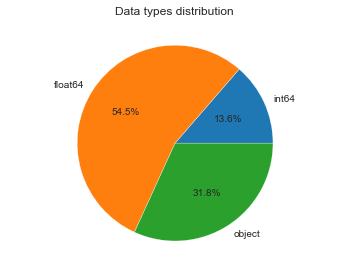

In [31]:
# Dataset data types distribution
plot_empirical_distribution(df_seattle.dtypes, var_type='quali', title='Data types')
# df_seattle.dtypes.value_counts().plot.pie()

In [32]:
df_seattle.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6385 entries, 0 to 6715
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   DataYear                         6385 non-null   int64  
 1   YearBuilt                        6385 non-null   int64  
 2   BuildingType                     6385 non-null   object 
 3   ListOfAllPropertyUseTypes        6385 non-null   object 
 4   PrimaryPropertyType              6385 non-null   object 
 5   LargestPropertyUseType           6385 non-null   object 
 6   SecondLargestPropertyUseType     6385 non-null   object 
 7   ThirdLargestPropertyUseType      6385 non-null   object 
 8   PropertyGFATotal                 6385 non-null   int64  
 9   LargestPropertyUseTypeGFA        6385 non-null   float64
 10  SecondLargestPropertyUseTypeGFA  6385 non-null   float64
 11  ThirdLargestPropertyUseTypeGFA   6385 non-null   float64
 12  NumberofBuildings   

### 2 - Univariate analysis <a class="anchor" id="third_2"></a>

#### 2.1 - Quantitatives variables :

#### 2.1.1 YearBuilt

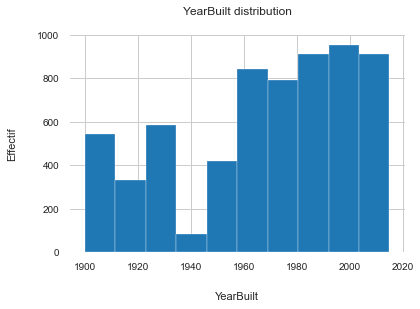

In [33]:
plot_empirical_distribution(df_seattle['YearBuilt'], density=False)
# Lowest year built class seems to be related to WW2 

#### 2.1.2 - Property ground floor area (GFA) variables 

In [34]:
gfa_cols = [col for col in df_seattle.columns if 'GFA' in col]
gfa_cols

['PropertyGFATotal',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA']

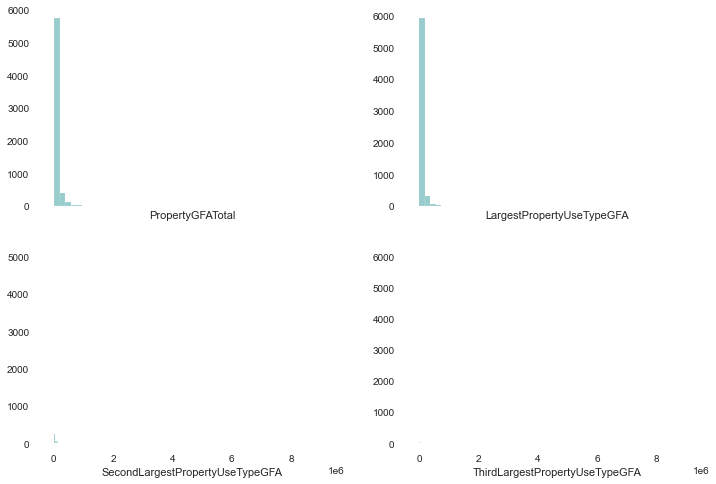

In [35]:
# Plot distribution for each property GFA variable

gfa_f, gfa_axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

gfa_axes_range = [gfa_axes[0,0], gfa_axes[0,1], gfa_axes[1,0], gfa_axes[1,1]]

for a, col in zip(gfa_axes_range, gfa_cols):
    sns.distplot(df_seattle[col], color="teal", kde=False, ax=a) # kde_kws={'bw': 1.5}

#### 2.1.3 - NumberofBuildings

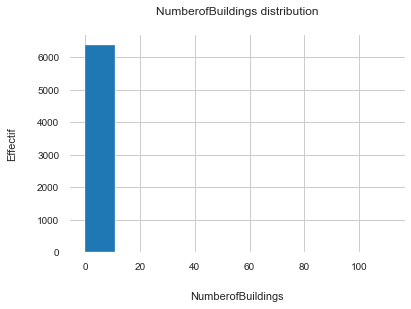

In [36]:
df_seattle['NumberofBuildings'] = df_seattle['NumberofBuildings'].astype(int)
plot_empirical_distribution(df_seattle['NumberofBuildings'], density=False)

In [37]:
measures_table(df_seattle, 'NumberofBuildings')

,NumberofBuildings
count,6385.000000
mean,1.070948
std,1.625150
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,111.000000


In [38]:
df_seattle[df_seattle['NumberofBuildings'] == 1].shape[0] / df_seattle['NumberofBuildings'].shape[0]

# 97% of the properties of the dataset contain only one building so we will separate the dataset into 2 subsets :
# - 1 working subset which lists all the unique properties
# - 1 second subset which lists the rest of the properties counting several buildings to their assets

0.9678935003915426

In [39]:
# Outliers (properties that contain more than one building)
df_multi_buildings = df_seattle[df_seattle['NumberofBuildings'] > 1].copy()
# We will first work on unique properties
df = df_seattle[df_seattle['NumberofBuildings'] == 1].copy()
# Remove NumberofBuilding from dataset
delete_cols(df, 'NumberofBuildings')

In [40]:
get_data_loss(df, df_seattle)
df.shape

Dataframe rows reduced by 3.2 % (6385 -> 6180)


(6180, 21)

#### 2.1.4 - NumberofFloors

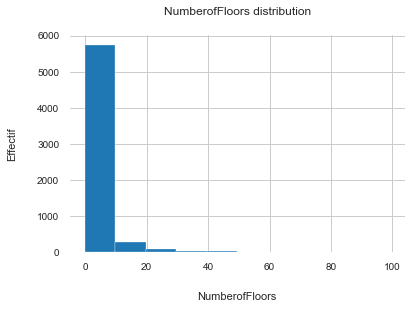

In [41]:
df['NumberofFloors'] = df['NumberofFloors'].astype(int)
plot_empirical_distribution(df['NumberofFloors'], density=False)

In [42]:
measures_table(df, 'NumberofFloors')

,NumberofFloors
count,6180.000000
mean,4.773948
std,5.588570
min,0.000000
25%,2.000000
50%,4.000000
75%,5.000000
max,99.000000


#### 2.1.5 - Energy variables 

In [43]:
en_cols = df.columns[-5:].tolist()
en_cols

['SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'Electricity(kBtu)',
 'NaturalGas(kBtu)',
 'SteamUse(kBtu)']

In [44]:
en_targets_cols = en_cols[:2]
en_other_cols = en_cols[-3:]
targets, other_en = 'Targets ', 'Other energy variables '
print(f'{targets:-<50} {en_targets_cols}')
print(f'{other_en:-<50} {en_other_cols}')

Targets ------------------------------------------ ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']
Other energy variables --------------------------- ['Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)']


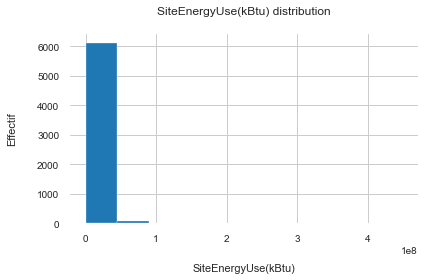

In [45]:
# 'SiteEnergyUse(kBtu)' distribution
plot_empirical_distribution(df['SiteEnergyUse(kBtu)'], density=False, save_as_img=True)

In [46]:
measures_table(df, 'SiteEnergyUse(kBtu)')

,SiteEnergyUse(kBtu)
count,6.180000e+03
mean,4.791522e+06
std,1.324148e+07
min,0.000000e+00
25%,9.180786e+05
50%,1.758580e+06
75%,4.048131e+06
max,4.483853e+08


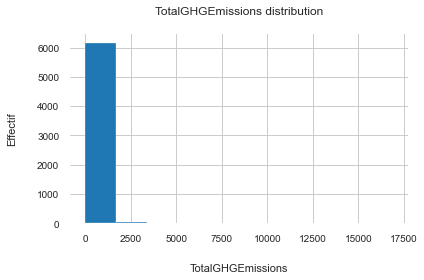

In [47]:
# 'TotalGHGEmissions' distribution
plot_empirical_distribution(df['TotalGHGEmissions'], density=False, save_as_img=True)

In [48]:
measures_table(df, 'TotalGHGEmissions')

,TotalGHGEmissions
count,6180.000000
mean,103.815036
std,393.637834
min,-0.800000
25%,9.287500
50%,32.765000
75%,89.060000
max,16870.980000


In [49]:
# An outlier has a negative value for gaz emissions target (investigate) 
df[df['TotalGHGEmissions'] < 0]

,DataYear,YearBuilt,BuildingType,ListOfAllPropertyUseTypes,PrimaryPropertyType,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,PropertyGFATotal,LargestPropertyUseTypeGFA,...,ThirdLargestPropertyUseTypeGFA,NumberofFloors,Neighborhood,Latitude,Longitude,SiteEnergyUse(kBtu),TotalGHGEmissions,Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu)
6546,2016,2013,NonResidential,Office,Small- and Mid-Sized Office,Office,0,0,52000,48159.0,...,0.0,6,CENTRAL,47.61432,-122.31257,342726.0938,-0.8,-115417.0,0.0,0.0


In [50]:
df_2016[df_2016['TotalGHGEmissions'] < 0]
# This building is considered as one of the greenest commercial building in the world.
# " In 2016, the Bullitt Center produced nearly 30 percent more energy than it needed for all uses,
#   from the solar panels on its roof."
# "at other times it produces enough surplus energy to "repay" such withdrawals,
#  yielding annual net positive energy"
# cf :  
# - https://en.wikipedia.org/wiki/Bullitt_Center
# - https://bullittcenter.org/

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
3206,49784,2016,NonResidential,Small- and Mid-Sized Office,Bullitt Center,1501 E. Madison St.,Seattle,WA,98122.0,7234600195,...,0.0,-33826.80078,-115417.0,0.0,0.0,False,Compliant,NaN,-0.8,-0.02


In [51]:
df_2016[df_2016['TotalGHGEmissions'] < 0][['DataYear', 'PropertyName', 'Address',
                                           'Electricity(kBtu)', 'SiteEnergyUse(kBtu)','TotalGHGEmissions']]

,DataYear,PropertyName,Address,Electricity(kBtu),SiteEnergyUse(kBtu),TotalGHGEmissions
3206,2016,Bullitt Center,1501 E. Madison St.,-115417.0,342726.0938,-0.8


In [52]:
df[df['TotalGHGEmissions'] <= 0]

,DataYear,YearBuilt,BuildingType,ListOfAllPropertyUseTypes,PrimaryPropertyType,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,PropertyGFATotal,LargestPropertyUseTypeGFA,...,ThirdLargestPropertyUseTypeGFA,NumberofFloors,Neighborhood,Latitude,Longitude,SiteEnergyUse(kBtu),TotalGHGEmissions,Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu)
44,2015,1920,NonResidential,"Non-Refrigerated Warehouse, Other, Retail Store",Retail Store,Retail Store,Non-Refrigerated Warehouse,Other,57428,34617.0,...,9783.0,2,DOWNTOWN,47.610764,-122.337677,0.000000e+00,0.0,0.0,0.0,0.0
572,2015,1929,NonResidential,"Office, Other - Technology/Science, Parking",Large Office,Office,Parking,Other - Technology/Science,216571,182604.0,...,6246.0,27,DOWNTOWN,47.607655,-122.335512,0.000000e+00,0.0,0.0,0.0,0.0
3853,2016,2008,NonResidential,"Personal Services (Health/Beauty, Dry Cleaning, etc), Retail Store, Supermarket/Grocery Store",Supermarket / Grocery Store,Supermarket/Grocery Store,Retail Store,"Personal Services (Health/Beauty, Dry Cleaning, etc)",57176,39500.0,...,5500.0,1,MAGNOLIA / QUEEN ANNE,47.637180,-122.377340,1.252517e+07,0.0,0.0,0.0,0.0
4663,2016,1974,Multifamily LR (1-4),Multifamily Housing,Low-Rise Multifamily,Multifamily Housing,0,0,37361,27732.0,...,0.0,4,LAKE UNION,47.642720,-122.328660,8.801155e+05,0.0,0.0,0.0,0.0
6546,2016,2013,NonResidential,Office,Small- and Mid-Sized Office,Office,0,0,52000,48159.0,...,0.0,6,CENTRAL,47.614320,-122.312570,3.427261e+05,-0.8,-115417.0,0.0,0.0


In [53]:
df[df['SiteEnergyUse(kBtu)'] <= 0]
# the first two lines (idx 44, 572) are common to those relating to gas emissions.
# So we just need to filter the data of this gas emissions variable

,DataYear,YearBuilt,BuildingType,ListOfAllPropertyUseTypes,PrimaryPropertyType,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,PropertyGFATotal,LargestPropertyUseTypeGFA,...,ThirdLargestPropertyUseTypeGFA,NumberofFloors,Neighborhood,Latitude,Longitude,SiteEnergyUse(kBtu),TotalGHGEmissions,Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu)
44,2015,1920,NonResidential,"Non-Refrigerated Warehouse, Other, Retail Store",Retail Store,Retail Store,Non-Refrigerated Warehouse,Other,57428,34617.0,...,9783.0,2,DOWNTOWN,47.610764,-122.337677,0.0,0.0,0.0,0.0,0.0
572,2015,1929,NonResidential,"Office, Other - Technology/Science, Parking",Large Office,Office,Parking,Other - Technology/Science,216571,182604.0,...,6246.0,27,DOWNTOWN,47.607655,-122.335512,0.0,0.0,0.0,0.0,0.0


In [54]:
# Filter this outlier (and zero values) from dataset (loss : 5 rows)
df = df[df['TotalGHGEmissions'] > 0]
df.shape

(6175, 21)

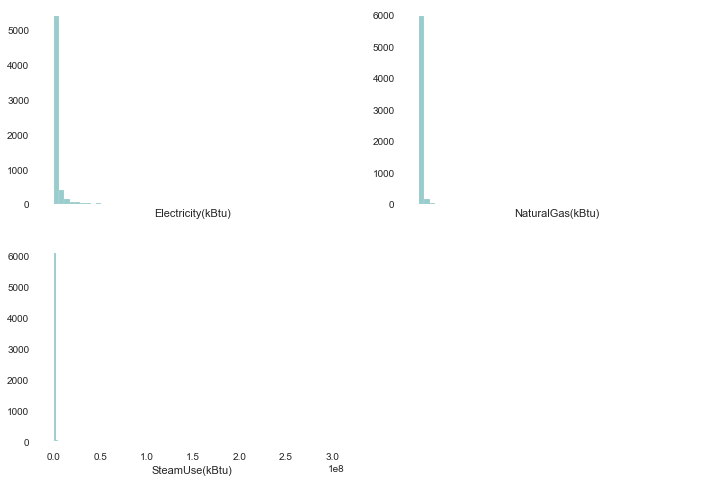

In [55]:
en_f, en_axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

en_axes_range = [en_axes[0, 0], en_axes[0, 1], en_axes[1, 0], en_axes[1, 1]]

for a, col in zip(en_axes_range, en_other_cols):
    sns.distplot(df[col], color="teal", kde=False, ax=a) # kde_kws={'bw': 1.5}
en_axes[1, 1].remove()

In [56]:
measures_table(df, 'SteamUse(kBtu)')

,SteamUse(kBtu)
count,6.175000e+03
mean,2.111748e+05
std,2.809853e+06
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.278697e+08


#### 2.2 - Qualitatives variables : (BuildingType, PrimaryPropertyType, Neighborhood ...)

In [57]:
unique_building_type = get_unique_values(df, 'BuildingType')
unique_building_type

Unique BuildingType : 8


['NonResidential',
 'Nonresidential COS',
 'Multifamily MR (5-9)',
 'SPS-District K-12',
 'Multifamily LR (1-4)',
 'Campus',
 'Multifamily HR (10+)',
 'Nonresidential WA']

In [58]:
unique_prim_prop_type = get_unique_values(df, 'PrimaryPropertyType')
unique_prim_prop_type

Unique PrimaryPropertyType : 30


['Hotel',
 'Other',
 'Mid-Rise Multifamily',
 'Mixed Use Property',
 'K-12 School',
 'College/University',
 'Small- and Mid-Sized Office',
 'Self-Storage Facility\n',
 'Large Office',
 'Low-Rise Multifamily',
 'Senior Care Community',
 'Medical Office',
 'Retail Store',
 'Hospital',
 'Residence Hall/Dormitory',
 'Non-Refrigerated Warehouse',
 'Distribution Center\n',
 'Worship Facility',
 'Supermarket/Grocery Store',
 'Refrigerated Warehouse',
 'High-Rise Multifamily',
 'Restaurant\n',
 'University',
 'Self-Storage Facility',
 'Residence Hall',
 'Warehouse',
 'Distribution Center',
 'Supermarket / Grocery Store',
 'Laboratory',
 'Restaurant']

In [59]:
# Clean PrimaryPropertyType
df['PrimaryPropertyType'] = df['PrimaryPropertyType'].map(lambda s: s.replace('\n', '').replace(' ', ''))

In [60]:
unique_prim_prop_type = get_unique_values(df, 'PrimaryPropertyType')
unique_prim_prop_type

Unique PrimaryPropertyType : 26


['Hotel',
 'Other',
 'Mid-RiseMultifamily',
 'MixedUseProperty',
 'K-12School',
 'College/University',
 'Small-andMid-SizedOffice',
 'Self-StorageFacility',
 'LargeOffice',
 'Low-RiseMultifamily',
 'SeniorCareCommunity',
 'MedicalOffice',
 'RetailStore',
 'Hospital',
 'ResidenceHall/Dormitory',
 'Non-RefrigeratedWarehouse',
 'DistributionCenter',
 'WorshipFacility',
 'Supermarket/GroceryStore',
 'RefrigeratedWarehouse',
 'High-RiseMultifamily',
 'Restaurant',
 'University',
 'ResidenceHall',
 'Warehouse',
 'Laboratory']

In [61]:
unique_largest_prop_type = get_unique_values(df, 'LargestPropertyUseType')
unique_largest_prop_type

Unique LargestPropertyUseType : 57


['Hotel',
 'Police Station',
 'Other - Entertainment/Public Assembly',
 'Multifamily Housing',
 'Library',
 'Fitness Center/Health Club/Gym',
 'Social/Meeting Hall',
 'Courthouse',
 'Other',
 'K-12 School',
 'College/University',
 'Automobile Dealership',
 'Office',
 'Self-Storage Facility',
 'Senior Care Community',
 'Medical Office',
 'Retail Store',
 'Hospital (General Medical & Surgical)',
 'Museum',
 'Repair Services (Vehicle, Shoe, Locksmith, etc)',
 'Other - Lodging/Residential',
 'Residence Hall/Dormitory',
 'Other/Specialty Hospital',
 'Financial Office',
 'Non-Refrigerated Warehouse',
 'Distribution Center',
 'Parking',
 'Worship Facility',
 'Laboratory',
 'Supermarket/Grocery Store',
 'Convention Center',
 'Urgent Care/Clinic/Other Outpatient',
 'Other - Services',
 'Strip Mall',
 'Wholesale Club/Supercenter',
 'Refrigerated Warehouse',
 'Other - Recreation',
 'Lifestyle Center',
 'Data Center',
 'Other - Mall',
 'Manufacturing/Industrial Plant',
 'Restaurant',
 'Other - Edu

In [62]:
unique_second_prop_type = get_unique_values(df, 'SecondLargestPropertyUseType')
unique_second_prop_type

Unique SecondLargestPropertyUseType : 51


[0,
 'Parking',
 'Office',
 'Restaurant',
 'K-12 School',
 'Non-Refrigerated Warehouse',
 'Other - Education',
 'Vocational School',
 'Retail Store',
 'Other - Entertainment/Public Assembly',
 'Data Center',
 'Swimming Pool',
 'Other',
 'Courthouse',
 'Residence Hall/Dormitory',
 'Distribution Center',
 'Self-Storage Facility',
 'Other - Services',
 'Movie Theater',
 'Supermarket/Grocery Store',
 'Medical Office',
 'Laboratory',
 'Other - Recreation',
 'Convenience Store without Gas Station',
 'Fitness Center/Health Club/Gym',
 'Performing Arts',
 'College/University',
 'Other - Restaurant/Bar',
 'Adult Education',
 'Multifamily Housing',
 'Bar/Nightclub',
 'Financial Office',
 'Repair Services (Vehicle, Shoe, Locksmith, etc)',
 'Other - Lodging/Residential',
 'Bank Branch',
 'Food Service',
 'Worship Facility',
 'Senior Care Community',
 'Refrigerated Warehouse',
 'Hotel',
 'Food Sales',
 'Other/Specialty Hospital',
 'Other - Public Services',
 'Manufacturing/Industrial Plant',
 'Soci

In [63]:
unique_third_prop_type = get_unique_values(df, 'ThirdLargestPropertyUseType')
unique_third_prop_type

Unique ThirdLargestPropertyUseType : 44


[0,
 'Restaurant',
 'Swimming Pool',
 'Data Center',
 'Office',
 'Retail Store',
 'Other - Entertainment/Public Assembly',
 'Other',
 'Distribution Center',
 'Food Service',
 'Other - Services',
 'Medical Office',
 'Parking',
 'Other - Lodging/Residential',
 'K-12 School',
 'Fitness Center/Health Club/Gym',
 'Social/Meeting Hall',
 'Pre-school/Daycare',
 'Convenience Store without Gas Station',
 'Financial Office',
 'Non-Refrigerated Warehouse',
 'Other - Restaurant/Bar',
 'Other - Education',
 'Multifamily Housing',
 'Laboratory',
 'Bank Branch',
 'Hotel',
 'Other - Recreation',
 'Personal Services (Health/Beauty, Dry Cleaning, etc)',
 'Self-Storage Facility',
 'Refrigerated Warehouse',
 'Manufacturing/Industrial Plant',
 'Fast Food Restaurant',
 'Bar/Nightclub',
 'Food Sales',
 'Supermarket/Grocery Store',
 'Other/Specialty Hospital',
 'Worship Facility',
 'Strip Mall',
 'Enclosed Mall',
 'Residence Hall/Dormitory',
 'Other - Technology/Science',
 'College/University',
 'Other - Publ

In [64]:
unique_neighborhood = get_unique_values(df, 'Neighborhood')
unique_neighborhood

Unique Neighborhood : 19


['DOWNTOWN',
 'SOUTHEAST',
 'NORTHEAST',
 'EAST',
 'CENTRAL',
 'NORTH',
 'MAGNOLIA / QUEEN ANNE',
 'LAKE UNION',
 'BALLARD',
 'GREATER DUWAMISH',
 'NORTHWEST',
 'SOUTHWEST',
 'DELRIDGE',
 'Delridge',
 'North',
 'Ballard',
 'Northwest',
 'Central',
 'DELRIDGE NEIGHBORHOODS']

In [65]:
# Normalize Neighborhood variable (capitalize)
df['Neighborhood'] = df['Neighborhood'].map(lambda s: s.capitalize())
df['Neighborhood'] = df['Neighborhood'].replace('Delridge neighborhoods', 'Delridge')

In [66]:
unique_neighborhood = get_unique_values(df, 'Neighborhood')
unique_neighborhood

Unique Neighborhood : 13


['Downtown',
 'Southeast',
 'Northeast',
 'East',
 'Central',
 'North',
 'Magnolia / queen anne',
 'Lake union',
 'Ballard',
 'Greater duwamish',
 'Northwest',
 'Southwest',
 'Delridge']

### 3 - Feature engineering  <a class="anchor" id="third_3"></a>

#### 3.1 - Creation of YearBuiltInterval, OldBuilding variables from YearBuilt

In [67]:
# The values of the YearBuilt variable are divided into 8 classes (quantiles)
year_built_cls = pd.qcut(df['YearBuilt'], 8)
year_built_cls.value_counts()

(1986.0, 1997.0]      797
(1899.999, 1920.0]    794
(1974.0, 1986.0]      787
(1963.0, 1974.0]      782
(1947.0, 1963.0]      770
(1920.0, 1947.0]      759
(1997.0, 2005.0]      757
(2005.0, 2015.0]      729
Name: YearBuilt, dtype: int64

In [68]:
# We create a variable that stores the different intervals of each class
df['YearBuiltInterval'] = ['{}-{}'.format(int(round(i.left)), int(round(i.right))) for i in year_built_cls]

In [69]:
df['OldBuilding'] = df['YearBuilt'].map(lambda x: 1 if int(x) < 2000 else 0)

#### 3.2 - Creation of Boolean variables qualifying the dominant type of energy used by the building

In [70]:
# Function which determine the dominant type of energy used according to the proportion 
# of this compared to the total amount of energy consumed (majority threshold)

def main_energy_type(value, col1, col2='SiteEnergyUse(kBtu)'):
    return 1 if (value[col1] / value[col2]) > 0.5 else 0

energy_cond = (df['SiteEnergyUse(kBtu)'] > 0) & (df['TotalGHGEmissions'] > 0)

# Filter zero values from targets 
df = df[energy_cond]

df['Main_energy_electricity'] = df.apply(lambda v: main_energy_type(v, 'Electricity(kBtu)'), axis=1)
df['Main_energy_gas'] = df.apply(lambda v: main_energy_type(v, 'NaturalGas(kBtu)'), axis=1)
df['Main_energy_steam'] = df.apply(lambda v: main_energy_type(v, 'SteamUse(kBtu)'), axis=1)

#### 3.3 - Creation of variables qualifying the proportion of energy used by the building by type of energy

In [71]:
for col in en_other_cols: # 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)'
    col_cleaned = col.replace('(kBtu)', '')
    df[col_cleaned+'_proportion'] = (df[col] / df['SiteEnergyUse(kBtu)'])*100
    df[col_cleaned+'_proportion'] = df.loc[:, col_cleaned+'_proportion'].round(1)

# Check the consistency of the total of the proportions
df['check_energy_proportion'] = df[df.columns[-3:]].sum(axis=1).round()

In [72]:
df[df.columns[-4:]][df['check_energy_proportion'] > 100]

,Electricity_proportion,NaturalGas_proportion,SteamUse_proportion,check_energy_proportion
564,100.0,11.7,0.0,112.0
1201,95.4,36.1,0.0,132.0
1308,100.0,28.5,0.0,128.0
3546,100.0,1.3,0.0,101.0
3903,94.1,27.4,0.0,122.0
6632,36.1,77.5,0.0,114.0
6690,164.5,0.0,0.0,164.0


In [73]:
df[df.columns[-4:]][df['check_energy_proportion'] < 100]
# N.B : when this amount is less than 100, it is possible that the building has incorrectly informed
# its energy consumption or else it uses an additional energy source which is not indicated here

,Electricity_proportion,NaturalGas_proportion,SteamUse_proportion,check_energy_proportion
69,48.8,0.0,29.2,78.0
70,71.4,0.0,25.1,96.0
71,29.3,0.0,40.3,70.0
73,43.7,0.0,43.5,87.0
75,67.1,0.0,18.7,86.0
270,87.6,0.0,0.0,88.0
451,99.4,0.0,0.0,99.0
578,95.4,0.0,0.0,95.0
1291,60.3,13.0,9.4,83.0
1301,41.0,0.0,54.6,96.0


In [74]:
# We decide here to filter the observations for which the amount of the energetic proportions is not equal to 100
df_cleaned = df[df['check_energy_proportion'] == 100.0]
get_data_loss(df_cleaned, df)
df = df_cleaned

Dataframe rows reduced by 0.7 % (6175 -> 6130)


#### 3.4 - Categorize targets

In [75]:
# Function which discretize a target variable into equal-sized buckets based on sample quantiles
# (3 classes required ('low', 'medium', 'high'))
def categorize_target(df, col):
    return pd.qcut(df[col], 3, precision=1, labels=['low', 'medium', 'high'])

df['SiteEnergyUseCat'] = categorize_target(df, 'SiteEnergyUse(kBtu)').astype(str)
df['TotalGHGEmissionsCat'] = categorize_target(df, 'TotalGHGEmissions').astype(str)

#### 3.5 - Handling latitude and longitude columns

In [76]:
# Geospatial module (cf : https://github.com/gboeing/osmnx)
import osmnx as ox
# Seattle geodataframe
seattle_gdf = ox.gdf_from_place('Seattle')
# Extract Seattle geographic boundaries coordinates
seattle_bbox = seattle_gdf.loc[:, seattle_gdf.columns[2:]]
# Coordinate deviations along a north-south axis -> (North = 0 else South)
df['North_south_dist'] = seattle_bbox.loc[:, 'bbox_north'].values - df.loc[:, 'Latitude'].values
# Coordinate deviations along a east-west axis -> (East = 0 else West)
df['East_west_dist'] = seattle_bbox.loc[:, 'bbox_east'].values - df.loc[:, 'Longitude'].values

#### 3.6 - Creation of  TotalPropertyUseTypes variable from ListOfAllPropertyUseTypes

In [77]:
# We create here a variable which counts the total number of types of uses of a property
df['ListOfAllPropertyUseTypes'] = df.loc[:, 'ListOfAllPropertyUseTypes'].map(lambda s: s.split(','))
df['TotalPropertyUseTypes'] = df.loc[:, 'ListOfAllPropertyUseTypes'].map(len)
delete_cols(df, 'ListOfAllPropertyUseTypes')

### 4 - Feature scaling <a class="anchor" id="third_4"></a>

In [78]:
# Log scaling
non_standard_cols = en_cols + gfa_cols

def log_scaling(df, cols):
    for col in cols:
        df.loc[:, col] = df.loc[:, col].map(lambda x: np.log(x) if x > 0 else x)

log_scaling(df, non_standard_cols)

### 5 - Factorial analysis (PCA) <a class="anchor" id="third_5"></a>

In [79]:
numeric_cols = ['PrimaryPropertyType',
                'PropertyGFATotal',
                'NumberofFloors',
                'North_south_dist',
                'East_west_dist',
                'TotalPropertyUseTypes'] + en_cols

df_pca =  df[numeric_cols].copy()
df_pca.head(2)

,PrimaryPropertyType,PropertyGFATotal,NumberofFloors,North_south_dist,East_west_dist,TotalPropertyUseTypes,SiteEnergyUse(kBtu),TotalGHGEmissions,Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu)
0,Hotel,11.390012,12,0.121945,0.113564,1,15.758764,5.519178,15.120096,14.056406,14.520108
1,Hotel,11.547964,11,0.121030,0.108925,3,15.938279,5.574091,15.177874,15.308187,0.000000


In [80]:
# PCA by first type of property
pca_model = PCAlizer(df_pca, preprocess_data=True, category_label='PrimaryPropertyType')
pca_model.fit()

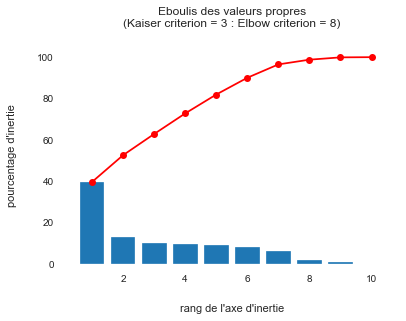

In [81]:
pca_model.scree_plot()

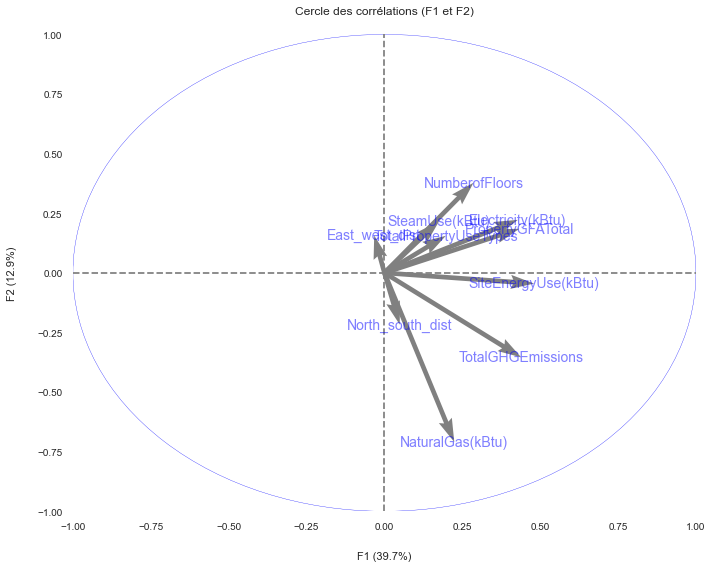

In [82]:
pca_model.plot_correlation_circle(n_plan=1, labels=pca_model.features, save_as_img=True)
# North_south_dist seems to be correlated to TotalGHGEmissions
# Hypothesis : gaz emissions depend on building longitude

#### Hypothesis :
- **First hypothesis : energy consumption seems to be correlated to the property ground floor area**
    - H0 : energy consumption is independent to the property ground floor area
    - H1 : energy consumption is correlated of the property ground floor area 
- **Second hypothesis : gaz emissions seems to be correlated to the energy consumption**
    - H0 : gaz emissions is independent of the energy consumption
    - H1 : gaz emissions is correlated of the energy consumption

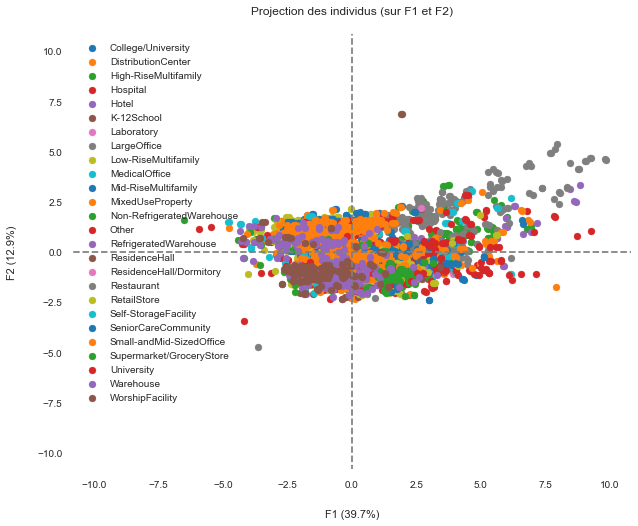

In [83]:
pca_model.plot_factorial_planes(n_plan=1,
                                #labels=centroids_cat,
                                illustrative_var=pca_model.categories)

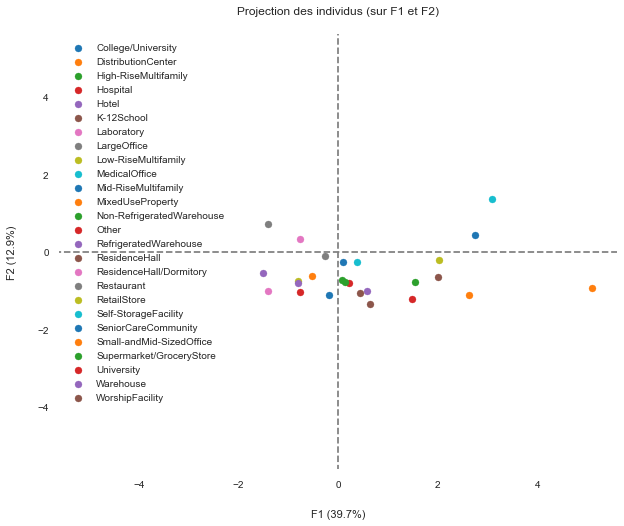

In [84]:
x_centroids_projected, centroids_cat = pca_model.get_centroids()
pca_model.plot_factorial_planes(n_plan=1, X_projected=x_centroids_projected,
                                #labels=centroids_cat,
                                illustrative_var=centroids_cat)

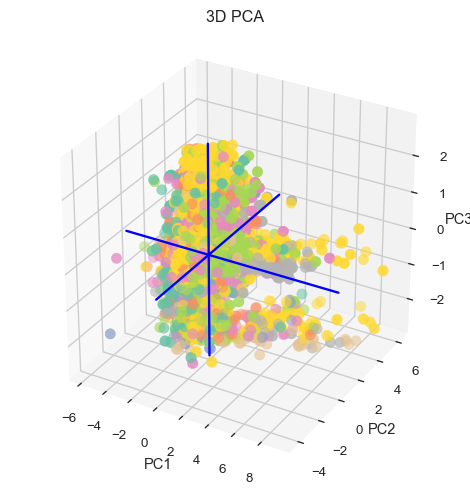

In [85]:
pca_model.plot_3d_factorial_plan()

### 6 - Multivariate analysis <a class="anchor" id="third_6"></a>

In [86]:
# data_scan(df, to_html=True)

#### 6.1 - analysis of the relationships between target and feature variables 

#### 6.1.1 - Energy consumption & gas emissions by type of building

In [87]:
def gaz_and_energy_groupby(df, x='BuildingType'):
    cols_filtered = [x, 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions']
    df_quanti = df[cols_filtered]
    g = df_quanti.groupby(x).sum()
    g.reset_index(level=0, inplace=True)
    g.sort_values(by=['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'], inplace=True)
    g['TotalGHGEmissions/SiteEnergyUse(kBtu)'] = g['TotalGHGEmissions'] / g['SiteEnergyUse(kBtu)']
    # CO2 Emissions per energy consumption ratio
    g['TotalGHGEmissions/SiteEnergyUse(kBtu)'] = g['TotalGHGEmissions/SiteEnergyUse(kBtu)'].round(2)
    return g

gaz_and_energy_groupby(df)

,BuildingType,SiteEnergyUse(kBtu),TotalGHGEmissions,TotalGHGEmissions/SiteEnergyUse(kBtu)
6,Nonresidential WA,14.972649,3.098740,0.21
0,Campus,370.587896,126.381902,0.34
7,SPS-District K-12,1471.379765,412.795170,0.28
5,Nonresidential COS,1774.665076,499.158377,0.28
1,Multifamily HR (10+),3251.413511,1025.699776,0.32
3,Multifamily MR (5-9),15451.216687,3683.204484,0.24
2,Multifamily LR (1-4),26380.722099,4919.258586,0.19
4,NonResidential,40452.733910,10511.135904,0.26


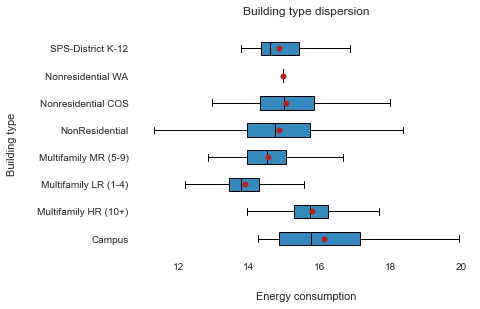

In [88]:
plot_dispersion(df, X='BuildingType', Y='SiteEnergyUse(kBtu)', xlabel='Energy consumption',
                ylabel='Building type')

In [89]:
# Scope building type outlier
df['BuildingType'][df['BuildingType'] == 'Nonresidential WA'].describe()

count     1                
unique    1                
top       Nonresidential WA
freq      1                
Name: BuildingType, dtype: object

In [90]:
# Filter building type outlier
df = df[df['BuildingType'] != 'Nonresidential WA']

../mlearn/analyzer/univariate.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by=[X], inplace=True)


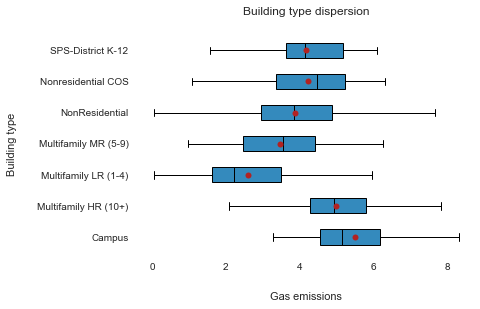

In [91]:
plot_dispersion(df, X='BuildingType', Y='TotalGHGEmissions', xlabel='Gas emissions',
                ylabel='Building type')

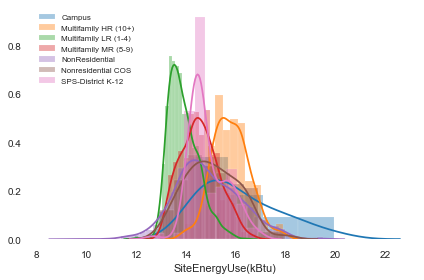

In [92]:
# Energy consumption distribution for each BuildingType (aggregated)

plt.figure()
for cat in df['BuildingType'].unique():
    sns.distplot(df[df['BuildingType']==cat]['SiteEnergyUse(kBtu)'], label=cat)
plt.legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.savefig('BuildingType_SiteEnergyUse.jpg')
plt.show()

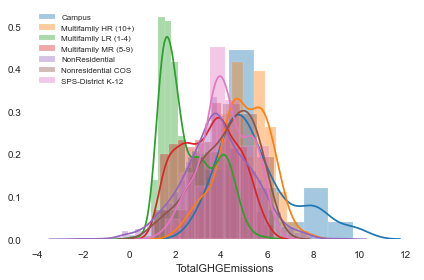

In [93]:
# Gaz emissions distribution for each BuildingType (aggregated)

plt.figure()
for cat in df['BuildingType'].unique():
    sns.distplot(df[df['BuildingType']==cat]['TotalGHGEmissions'], label=cat)
plt.legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.savefig('BuildingType_TotalGHGEmissions.jpg')
plt.show()

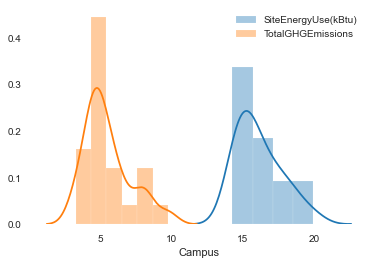

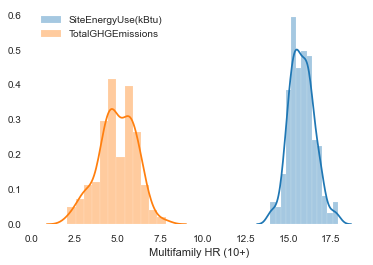

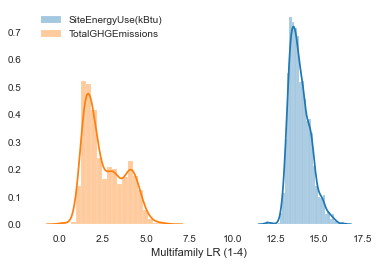

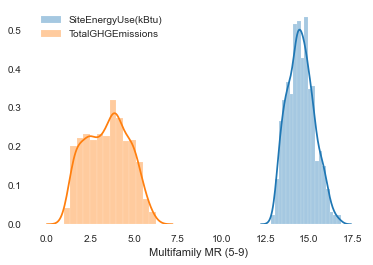

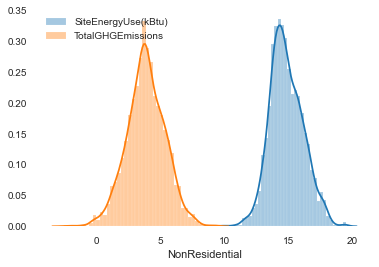

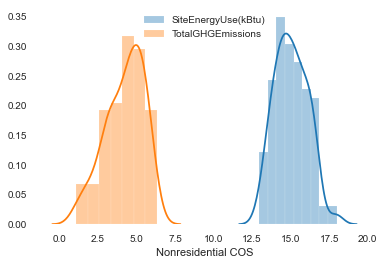

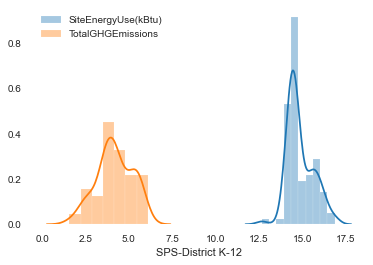

In [94]:
# Energy consumption & Gaz emissions distributions for each building type

for cat in df['BuildingType'].unique():
    plt.figure()
    sns.distplot(df[df['BuildingType'] == cat]['SiteEnergyUse(kBtu)'], axlabel=cat, label='SiteEnergyUse(kBtu)')
    sns.distplot(df[df['BuildingType'] == cat]['TotalGHGEmissions'], axlabel=cat, label='TotalGHGEmissions')
    plt.legend()

#### 6.1.2 - Energy consumption & gas emissions by neighborhood

In [95]:
gaz_and_energy_groupby(df, 'Neighborhood')

,Neighborhood,SiteEnergyUse(kBtu),TotalGHGEmissions,TotalGHGEmissions/SiteEnergyUse(kBtu)
2,Delridge,2133.840751,494.942063,0.23
11,Southeast,2332.988757,532.277671,0.23
1,Central,3232.731822,758.357011,0.23
0,Ballard,3528.696308,808.900051,0.23
12,Southwest,4127.690473,826.310518,0.20
8,North,4922.868682,1014.357459,0.21
10,Northwest,5807.577695,1245.844158,0.21
6,Lake union,6794.766297,1686.243429,0.25
9,Northeast,6995.686646,1542.813488,0.22
5,Greater duwamish,9768.598975,2252.616349,0.23


In [96]:
# gaz_and_energy_groupby(df, 'PrimaryPropertyType')

In [97]:
# Energy consumption distribution for each neighborhood

# plot_facet_grid(df, 'SiteEnergyUse(kBtu)', 'Neighborhood', col_wrap=4, h=3)

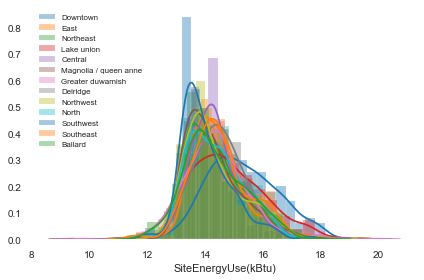

In [98]:
# Energy consumption distribution for each neighborhood (aggregated)

plt.figure()
for cat in df['Neighborhood'].unique():
    sns.distplot(df[df['Neighborhood']==cat]['SiteEnergyUse(kBtu)'], label=cat)
plt.legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.savefig('Neighborhood_SiteEnergyUse.jpg')
plt.show()

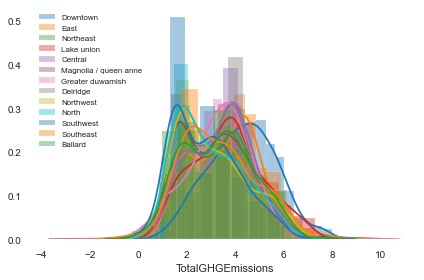

In [99]:
# Gaz emissions distribution for each neighborhood

plt.figure()
for cat in df['Neighborhood'].unique():
    sns.distplot(df[df['Neighborhood']==cat]['TotalGHGEmissions'], label=cat)
plt.legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.savefig('Neighborhood_TotalGHGEmissions.jpg')
plt.show()

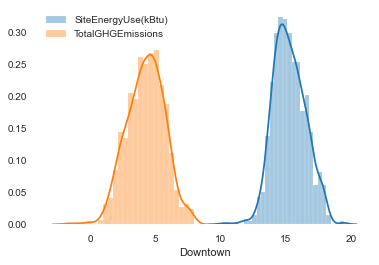

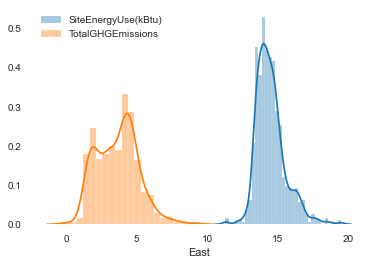

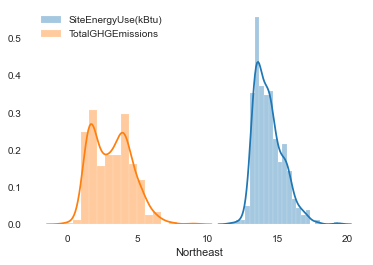

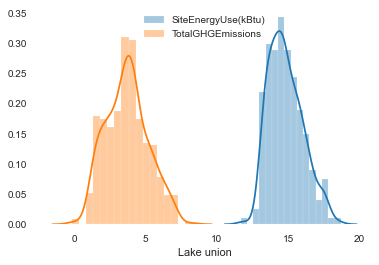

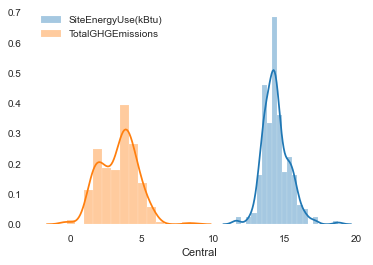

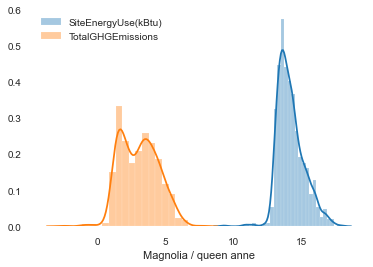

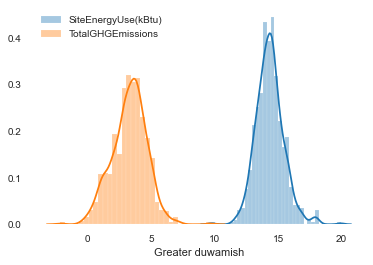

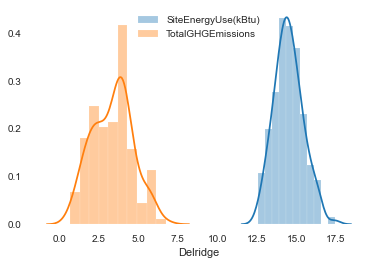

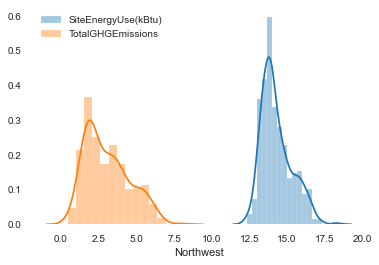

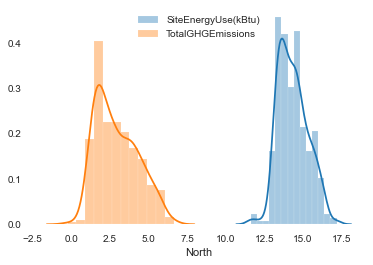

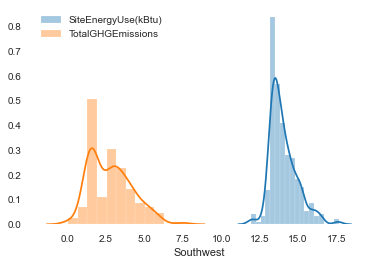

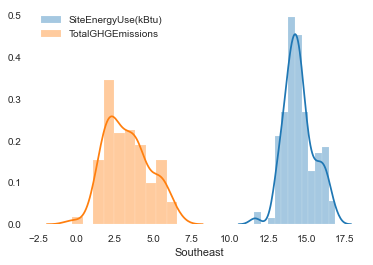

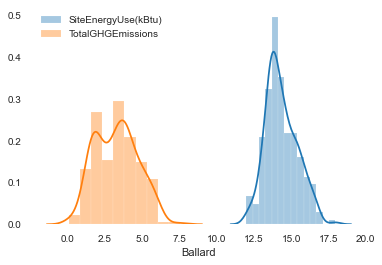

In [100]:
# Energy consumption & Gaz emissions distributions for each neighborhood

for col in df['Neighborhood'].unique():
    plt.figure()
    sns.distplot(df[df['Neighborhood'] == col]['SiteEnergyUse(kBtu)'], axlabel=col, label='SiteEnergyUse(kBtu)')
    sns.distplot(df[df['Neighborhood'] == col]['TotalGHGEmissions'], axlabel=col, label='TotalGHGEmissions')
    plt.legend()

In [101]:
# Energy consumption & Gaz emissions distributions for each neighborhood (grid version)

# neighbor_f, neighbor_axes = plt.subplots(4, 4, figsize=(12, 8), sharex=True)

# neighbor_axes_grid = np.indices((4, 4))

# neighbor_axes_range = [neighbor_axes[x, y] for x, y in zip(neighbor_axes_grid[0].ravel(),
#                                                            neighbor_axes_grid[1].ravel())]

# for a, col in zip(neighbor_axes_range, df['Neighborhood'].unique()):
#     sns.distplot(df[df['Neighborhood'] == col]['SiteEnergyUse(kBtu)'],
#                  color="teal", ax=a, axlabel=col, label='TotalGHGEmissions')
#     sns.distplot(df[df['Neighborhood'] == col]['TotalGHGEmissions'],
#                  color="green", ax=a, axlabel=col, label='SiteEnergyUse(kBtu)')
# plt.legend(['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'])
    
# for a in neighbor_axes_range[-3:]:
#     a.remove()

#### Hypothesis :
- **Third hypothesis : energy consumption seems to be related to the neighborhood**
    - H0 : energy consumption is independent of the neighborhood
    - H1 : energy consumption is dependent of the neighborhood 
- **Fourth hypothesis : gaz emissions seems to be related to the neighborhood**
    - H0 : gaz emissions is independent of the neighborhood
    - H1 : gaz emissions is dependent of the neighborhood
- **Fifth hypothesis : energy consumption seems to be related to the building type**
    - H0 : energy consumption is independent of the building type
    - H1 : energy consumption is dependent of the building type 
- **Sixth hypothesis : gaz emissions seems to be related to the building type**
    - H0 : gaz emissions is independent of the building type
    - H1 : gaz emissions is dependent of the building type

#### 6.1.3 - GFA variables by type of building

../mlearn/analyzer/univariate.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by=[X], inplace=True)


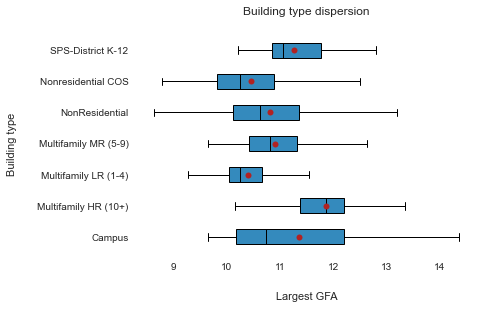

In [102]:
plot_dispersion(df, X='BuildingType', Y='LargestPropertyUseTypeGFA', xlabel='Largest GFA',
                ylabel='Building type')

#### 6.1.4 - GFA variables by type of neighborhood

../mlearn/analyzer/univariate.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by=[X], inplace=True)


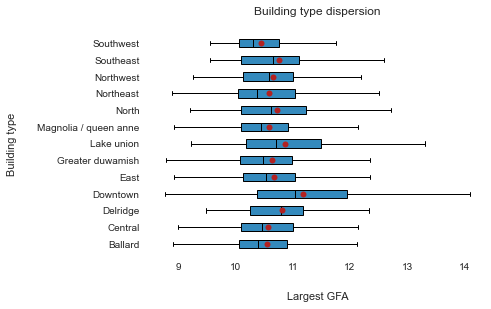

In [103]:
plot_dispersion(df, X='Neighborhood', Y='LargestPropertyUseTypeGFA', xlabel='Largest GFA',
                ylabel='Building type')

In [104]:
# (optional) geospatial dataviz (neighbor)

# import geopandas as gpd
# from shapely.geometry import Point, MultiPolygon, Polygon
# from keplergl import KeplerGl


# def visualize_spatial_data(df, groupby_col='Neighborhood', save_as_html=False):
#     coords_cols = ['Latitude', 'Longitude']
#     geometry_data = [Point((lon, lat)) for lat, lon in df[coords_cols].values]
#     gdf = gpd.GeoDataFrame(df, geometry=geometry_data)
#     gdf = gdf.dissolve(by=groupby_col, aggfunc='mean')
#     gdf.geometry = gdf.geometry.apply(lambda x: Polygon(x).convex_hull)
#     gdf.reset_index(inplace=True)
#     seattle_map = KeplerGl(height=800, data={'seattle': gdf.to_json()})
#     if save_as_html:
#         seattle_map.save_to_html()
#     return seattle_map

# visualize_spatial_data(df)

#### 6.2 - Linear correlations

#### 6.2.1 - Correlations matrix

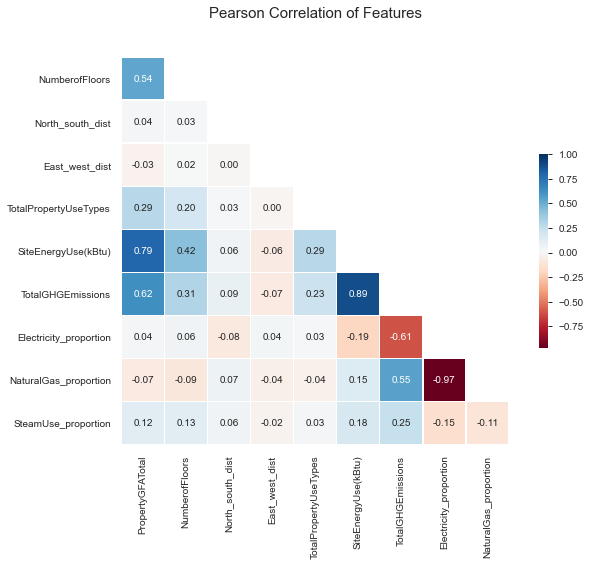

In [105]:
numeric_cols_filtered = [col for col in numeric_cols if col not in en_other_cols]
numeric_cols_extended = numeric_cols_filtered + ['Electricity_proportion',
                                                 'NaturalGas_proportion',
                                                 'SteamUse_proportion']

df_quanti = df[numeric_cols_extended]

correlation_matrix(df_quanti.iloc[:, 1:], as_chart=True, size=(10,8), save_as_img=True)

In [106]:
# sns.clustermap(df_quanti.iloc[:, 1:].corr())

In [107]:
ten_first_linear_corr = get_top_n_correlations(df_quanti.iloc[:, 1:], n=10, abs_corr=False)
ten_first_linear_corr

SiteEnergyUse(kBtu)    TotalGHGEmissions        0.886972
PropertyGFATotal       SiteEnergyUse(kBtu)      0.794320
                       TotalGHGEmissions        0.622465
TotalGHGEmissions      NaturalGas_proportion    0.550802
PropertyGFATotal       NumberofFloors           0.535177
NumberofFloors         SiteEnergyUse(kBtu)      0.424887
                       TotalGHGEmissions        0.311412
PropertyGFATotal       TotalPropertyUseTypes    0.293128
TotalPropertyUseTypes  SiteEnergyUse(kBtu)      0.289011
TotalGHGEmissions      SteamUse_proportion      0.245787
dtype: float64

#### 6.2.2 - Linearity hypothesis

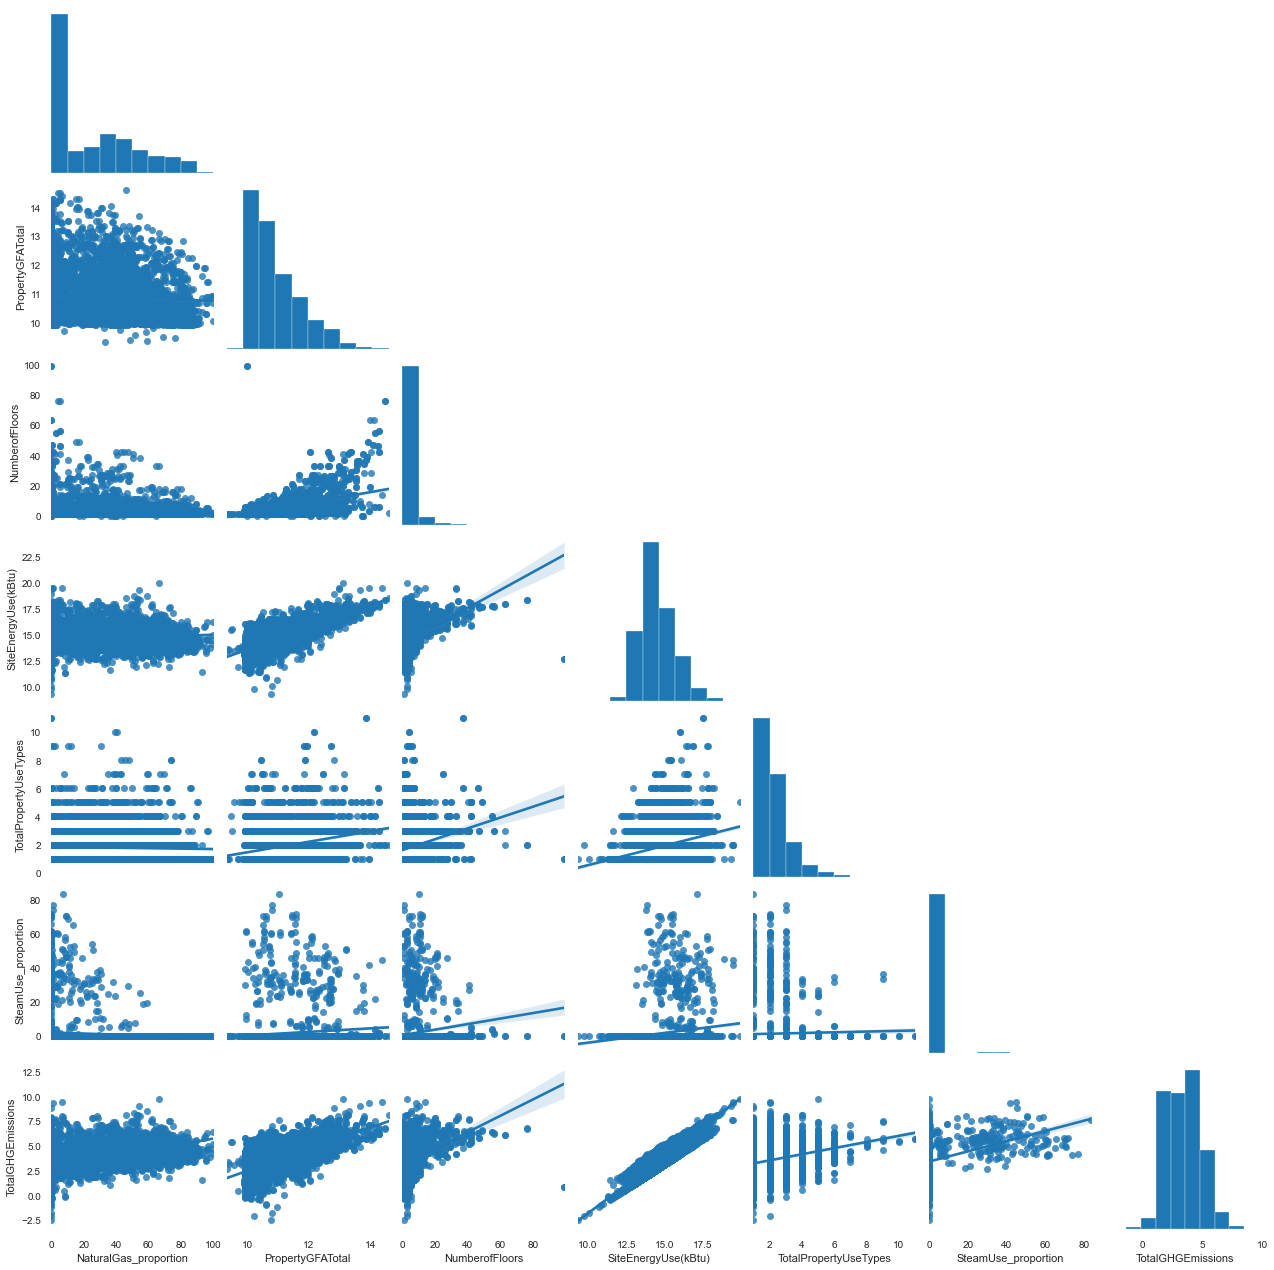

In [108]:
# Get unique labels from the ten first linear correlations
ten_first_linear_corr_cols = list(set([x for d in ten_first_linear_corr.index.tolist() for x in d]))

sns.pairplot(df[ten_first_linear_corr_cols], corner=True, kind='reg')
plt.show()

#### 6.2.3 - Normality hypothesis (residue analysis)

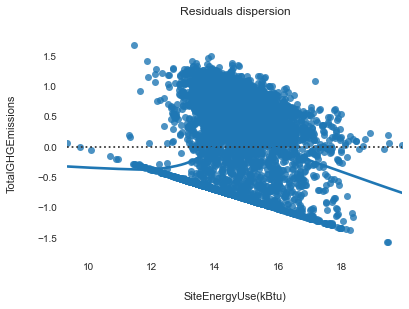

In [109]:
plot_residuals(df, 'SiteEnergyUse(kBtu)',  'TotalGHGEmissions')

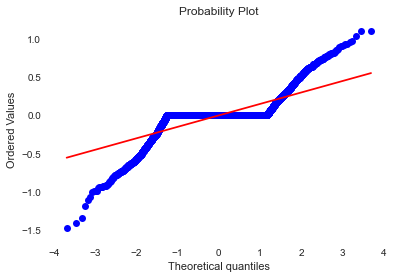

In [110]:
# Normal probability plot ("droite de Henry")
df_enery_use_renamed = df.rename(columns={'SiteEnergyUse(kBtu)': 'SiteEnergyUse'})
df_henry_plot = df_enery_use_renamed[['SiteEnergyUse',  'TotalGHGEmissions']]
r2, pval, model_fit = anova_stats_model(df_henry_plot, 'SiteEnergyUse',  'TotalGHGEmissions')
residue_normality_test(model_fit, test_type='npp')

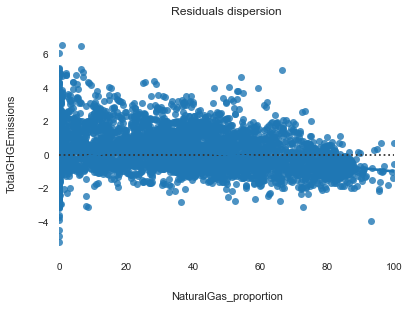

In [111]:
plot_residuals(df, 'NaturalGas_proportion', 'TotalGHGEmissions')

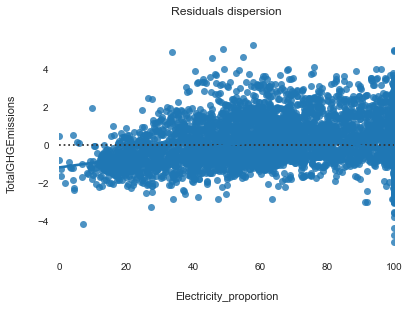

In [112]:
plot_residuals(df, 'Electricity_proportion', 'TotalGHGEmissions')

In [113]:
# plot_residuals(df[df['SteamUse_proportion'] > 0], 'SteamUse_proportion', 'TotalGHGEmissions')

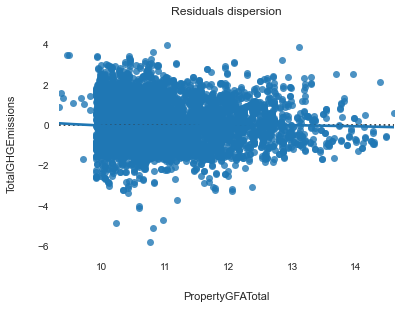

In [114]:
plot_residuals(df, 'PropertyGFATotal', 'TotalGHGEmissions')

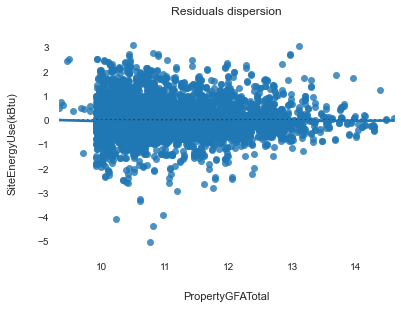

In [115]:
plot_residuals(df, 'PropertyGFATotal', 'SiteEnergyUse(kBtu)')

#### 6.3 - ANOVA

In [116]:
f'η = {anova_correlation_ratio(df, "BuildingType", "SiteEnergyUse(kBtu)")}'

'η = 0.19'

In [117]:
f'η = {anova_correlation_ratio(df, "Neighborhood", "SiteEnergyUse(kBtu)")}'

'η = 0.11'

In [118]:
f'η = {anova_correlation_ratio(df, "BuildingType", "TotalGHGEmissions")}'

'η = 0.19'

In [119]:
f'η = {anova_correlation_ratio(df, "Neighborhood", "TotalGHGEmissions")}'

'η = 0.09'

In [120]:
f'η = {anova_correlation_ratio(df, "YearBuiltInterval", "SiteEnergyUse(kBtu)")}'

'η = 0.05'

In [121]:
f'η = {anova_correlation_ratio(df, "YearBuiltInterval", "TotalGHGEmissions")}'

'η = 0.07'

In [122]:
# F-test

anova_en_targets_cols = sorted(en_targets_cols*2)
anova_cat_cols = ['BuildingType', 'Neighborhood']*2
etas = ['η = 0.19', 'η = 0.11', 'η = 0.19', 'η = 0.09']

for num_col, cat_col, eta in zip(anova_en_targets_cols, anova_cat_cols, etas):
    print(f'Anova ({eta}) {num_col}/{cat_col:-<50} {anova_test(df, num_col, cat_col)}')

Anova (η = 0.19) SiteEnergyUse(kBtu)/BuildingType-------------------------------------- Reject H0 (p-value < 0.05)
Anova (η = 0.11) SiteEnergyUse(kBtu)/Neighborhood-------------------------------------- Reject H0 (p-value < 0.05)
Anova (η = 0.19) TotalGHGEmissions/BuildingType-------------------------------------- Reject H0 (p-value < 0.05)
Anova (η = 0.09) TotalGHGEmissions/Neighborhood-------------------------------------- Reject H0 (p-value < 0.05)


#### Hypothesis :
- **First hypothesis : energy consumption seems to be correlated to the property ground floor area**
    - H0 : energy consumption is independent to the property ground floor area (**Rejected**)
    - H1 : energy consumption is correlated of the property ground floor area 
- **Second hypothesis : gaz emissions seems to be correlated to the energy consumption**
    - H0 : gaz emissions is independent of the energy consumption (**Rejected**)
    - H1 : gaz emissions is correlated of the energy consumption
- **Third hypothesis : energy consumption seems to be related to the neighborhood**
    - H0 : energy consumption is independent of the neighborhood (**Rejected**)
    - H1 : energy consumption is dependent of the neighborhood 
- **Fourth hypothesis : gaz emissions seems to be related to the neighborhood**
    - H0 : gaz emissions is independent of the neighborhood (**Rejected**)
    - H1 : gaz emissions is dependent of the neighborhood
- **Fifth hypothesis : energy consumption seems to be related to the building type**
    - H0 : energy consumption is independent of the building type (**Rejected**)
    - H1 : energy consumption is dependent of the building type 
- **Sixth hypothesis : gaz emissions seems to be related to the building type**
    - H0 : gaz emissions is independent of the building type (**Rejected**)
    - H1 : gaz emissions is dependent of the building type

#### 6.4 - Chi-2

'Reject H0'

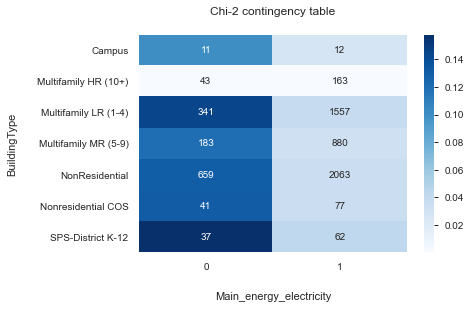

In [123]:
chi_2_test(df, "BuildingType", "Main_energy_electricity")

'Reject H0'

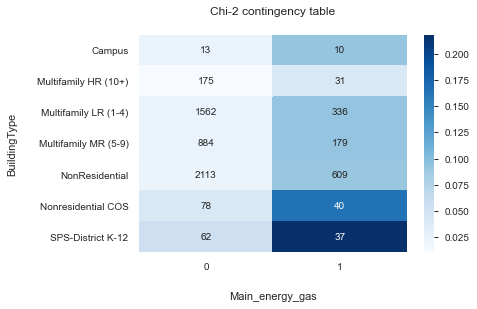

In [124]:
chi_2_test(df, "BuildingType", "Main_energy_gas")

'Reject H0'

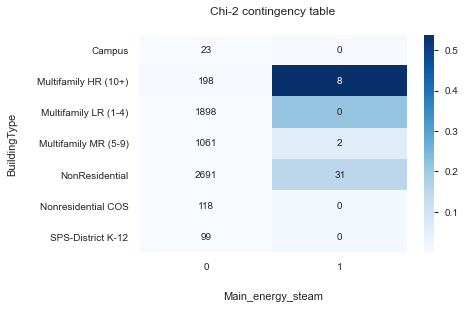

In [125]:
chi_2_test(df, "BuildingType", "Main_energy_steam")

'Reject H0'

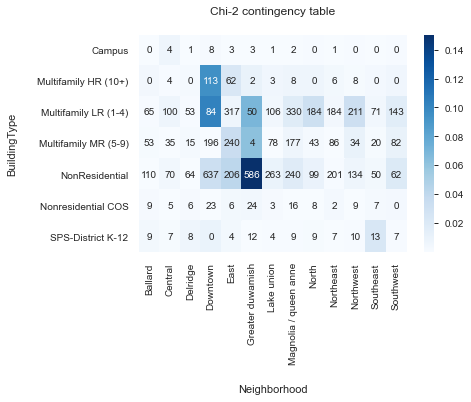

In [126]:
chi_2_test(df, "BuildingType", "Neighborhood")

'Reject H0'

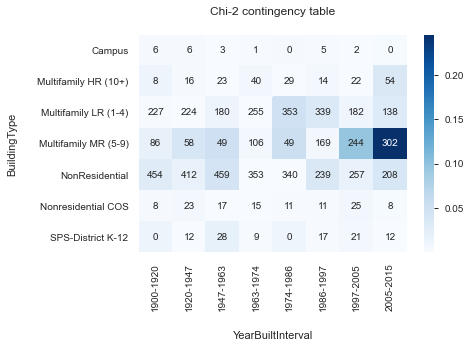

In [127]:
chi_2_test(df, "BuildingType", "YearBuiltInterval")

'Reject H0'

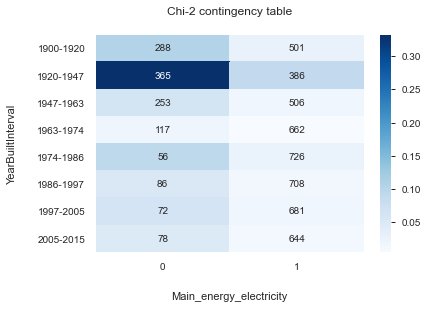

In [128]:
chi_2_test(df, "YearBuiltInterval", 'Main_energy_electricity')
# Buildings built between 1920 and 1947 are more likely to use gas as an energy resource

'Reject H0'

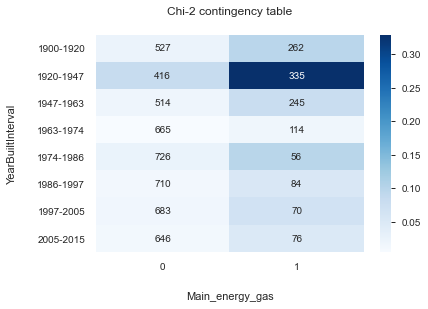

In [129]:
chi_2_test(df, "YearBuiltInterval", 'Main_energy_gas')
# Indeed we note here that the buildings of the years 1920 - 1947 are more often 
# associated with a mode of energy consumption using gas

'Reject H0'

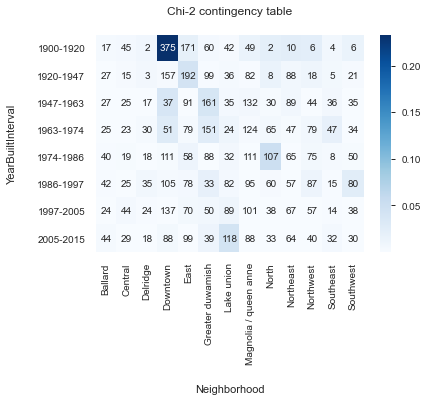

In [130]:
chi_2_test(df, "YearBuiltInterval", 'Neighborhood')

'Reject H0'

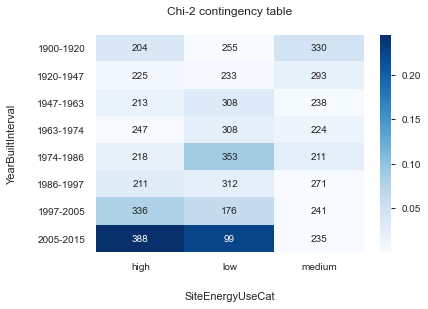

In [131]:
chi_2_test(df, "YearBuiltInterval", 'SiteEnergyUseCat')

'Reject H0'

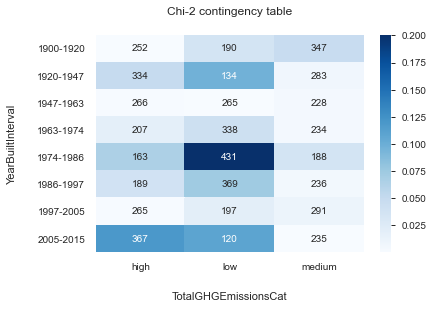

In [132]:
chi_2_test(df, "YearBuiltInterval", 'TotalGHGEmissionsCat')
# The buildings constructed during the years 1974-1986 seem to produce low greenhouse gas emissions

In [133]:
df.columns

Index(['DataYear', 'YearBuilt', 'BuildingType', 'PrimaryPropertyType',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'PropertyGFATotal',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'NumberofFloors', 'Neighborhood',
       'Latitude', 'Longitude', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)',
       'YearBuiltInterval', 'OldBuilding', 'Main_energy_electricity',
       'Main_energy_gas', 'Main_energy_steam', 'Electricity_proportion',
       'NaturalGas_proportion', 'SteamUse_proportion',
       'check_energy_proportion', 'SiteEnergyUseCat', 'TotalGHGEmissionsCat',
       'North_south_dist', 'East_west_dist', 'TotalPropertyUseTypes'],
      dtype='object')

# IV - Build modeling dataset <a class="anchor" id="fourth"></a>

In [134]:
# Filter model variables (avoid data leakage)
df.columns.tolist()

['DataYear',
 'YearBuilt',
 'BuildingType',
 'PrimaryPropertyType',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'PropertyGFATotal',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'NumberofFloors',
 'Neighborhood',
 'Latitude',
 'Longitude',
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'Electricity(kBtu)',
 'NaturalGas(kBtu)',
 'SteamUse(kBtu)',
 'YearBuiltInterval',
 'OldBuilding',
 'Main_energy_electricity',
 'Main_energy_gas',
 'Main_energy_steam',
 'Electricity_proportion',
 'NaturalGas_proportion',
 'SteamUse_proportion',
 'check_energy_proportion',
 'SiteEnergyUseCat',
 'TotalGHGEmissionsCat',
 'North_south_dist',
 'East_west_dist',
 'TotalPropertyUseTypes']

In [135]:
excluded_variables = ['DataYear', 'YearBuilt', 'YearBuiltInterval',
                      'Latitude', 'Longitude', 'check_energy_proportion',
                      'SiteEnergyUseCat', 'TotalGHGEmissionsCat'] + en_other_cols

In [136]:
# Transform categorical data in numerical

indicators_cols = ['BuildingType',
                   'PrimaryPropertyType',
                   'LargestPropertyUseType',
                   'SecondLargestPropertyUseType',
                   'ThirdLargestPropertyUseType',
                   'Neighborhood']

df_model_data = df.copy()

for col in indicators_cols:
    df_model_data = get_dummy_indicators(df_model_data, col, prefix_origin_col=True)

In [137]:
residual_variables = [col for col in df_model_data.columns.tolist() if col.endswith("0") is True] 
excluded_variables_extended = residual_variables + excluded_variables
df_model_data = df_model_data[[col for col in df_model_data.columns if col not in excluded_variables_extended]]
df_model_data.head(2)

,PropertyGFATotal,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,NumberofFloors,SiteEnergyUse(kBtu),TotalGHGEmissions,OldBuilding,Main_energy_electricity,Main_energy_gas,...,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,Neighborhood_Northwest,Neighborhood_Southeast,Neighborhood_Southwest
4219,11.016299,11.016299,0.000000,0.0,3,14.494209,3.761898,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4857,10.654927,10.396750,9.174506,0.0,4,13.865236,1.991976,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [138]:
# df_model_data.columns.tolist()

In [139]:
# Checking for duplicates (if is true there is no duplicates)
len(df_model_data.columns.unique()) == len(df_model_data.columns)

True

In [140]:
df_model_data.to_csv('../data/csv/seattle_model_data_no_ENERGYSTARScore.csv', index=False)